## Operational Metrics

While accuracy metrics give us a sense of decision correctness, we need to calculate metrics that reflect the priorities of the business case. For that purpose, we look at three metrics here

1. dollars per second -- For a set of decisions , looks at how much money was made for the merchant normalized by time spent on the decisions. 
2. average decision time -- Measure how fast the analysts were in making the decisions. Dollar value is not considered
3. percent dollar regret -- For a set of decisions, calculates how far the decisions were from the perfect case. The time is not considered


### Handling Suspicious

For decisions marked as 'suspicious', we use four strategies to understand the bounds of the metrics

1. Assume that the suspicious elavates the decision to a higher level analyst, and they get it right. We assume the decision is correct, and add a time penalty for the review process
2. Assume that those records are all declined (no decision time penalty)
3. Assume that those records are all approved (no decision time penalty)
4. Ignore the decisions from calculation (least desirable option)


In [2]:
import os
import sys
sys.path.append('../../')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import itertools
from sklearn.utils import resample

In [4]:
# from ducktales.feedzai_experiments.exp_results_analysis import fetch_all_decisions, grp_names_disp_name
from facct22.utils import get_db_con

from facct22.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    ttests_operational_metrics, assign_conf_mat_cell, _modify_value_and_time
)

In [5]:
cred_file = '../../conf/credentials.yaml'
engine = get_db_con(cred_file)

In [6]:
def plot_metrics_feedzai_style(metrics_dict, title='', confidence=0.9, legend=True):
    groups = list(metrics_dict.keys())
    x_pos = np.arange(len(groups))
    interval = stats.norm.ppf(1-(1-confidence)/2)
    means = [x['mean'] for _, x in metrics_dict.items()]
    errors = [x['se'] * interval for _, x in metrics_dict.items()]
    
    fig = plt.figure(constrained_layout=True, figsize=(6, 4))
    gs = fig.add_gridspec(5, 5)
    ax1 = fig.add_subplot(gs[:4, :])
    
    if legend:
        ax2 = fig.add_subplot(gs[-1:, 2:4])

    for j, grp in enumerate(pdr.keys()):
        a, caps, b = ax1.errorbar(
            means[j], (j), xerr=errors[j], ls='',
            elinewidth=2, capsize=10, color=colors[j]
        )

        ax1.scatter(means[j], (j), color=colors[j], marker='o')

        for cap in caps:
                cap.set_markeredgewidth(2)

        ax1.set_title(title, fontsize=11)
        ax1.yaxis.grid(False)
        ax1.xaxis.grid()

        ax1.set_yticks([])
        ax1.set_ylim(len(groups),-1)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax1.spines[spine].set_visible(False)

    if legend:
        color_part = []
        for i in range(len(pdr.keys())):
            color_part.append(Line2D([0], [0], color=colors[i], linewidth=2))
            color_legend = color_part, pdr.keys()

        metric_leg = ax2.axes.axes.legend(
            *color_legend,
            loc= 'upper center',
            ncol= len(groups),
            borderaxespad  = 0.,
            prop={'size':11},
            frameon=False,
        )

        ax2.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        for spine in ['top', 'right', 'left', 'bottom']:
            ax2.spines[spine].set_visible(False)

In [7]:
def plot_metrics(metrics, title='', tick_order=['Control-A', 'Control-B', 'TreeSHAP', 'TreeInterpreter', 'LIME'], confidence=0.9):
    """ Dollars made, per second"""
    # n = x
    # h = se * stats.t.ppf((1 + confidence) / 2., n-1)
#     fig, ax = plt.subplots(dpi=200)
    fig, ax = plt.subplots()
    ax.barh(
        np.arange(4, -1, -1), 
        [x['mean'] for _, x in metrics.iterrows()], 
        xerr=[x['se'] * stats.norm.ppf(1 - (1 - confidence) / 2) for _, x in metrics.iterrows()], #CI
        align='center', 
        alpha=0.7,  
        capsize=5,
        color=colors
    )
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels(tick_order[::-1])
    ax.set_title(title)
    sns.despine()
    ax.spines['left'].set_visible(False)

In [8]:
def plot_metrics2(metrics, plot_order, colors, title='', confidence=0.9, legend=True, xlim=None):
    interval = stats.norm.ppf(1-(1-confidence)/2)
    
    fig = plt.figure(constrained_layout=True, figsize=(6, 3), dpi=200)
    gs = fig.add_gridspec(5, 5)
    ax1 = fig.add_subplot(gs[:4, :])
        
    for i, group in enumerate(plot_order):
        msk = metrics['group'] == group
        row = metrics[msk].iloc[0, :]
        a, caps, b = ax1.errorbar(
            row['mean'], (i), xerr=row['se'] * interval, ls='',
            elinewidth=2, capsize=5, color=colors[i]
        )
        
        ax1.scatter(row['mean'], (i), color=colors[i], marker='o')
        for cap in caps:
            cap.set_markeredgewidth(2)
        for spine in ['top', 'right', 'left', 'bottom']:
            ax1.spines[spine].set_visible(False)
        ax1.set_yticks([])
    
    ax1.xaxis.grid()
    ax1.set_title(title)
    if xlim is not None:
        ax1.set_xlim(xlim)
        
    if legend:
        ax2 = fig.add_subplot(gs[-1:, 2:4])
        color_part = []
        for i in range(len(metrics)):
            color_part.append(Line2D([0], [0], color=colors[i], linewidth=2))
            color_legend = color_part, plot_order

        metric_leg = ax2.axes.axes.legend(
            *color_legend,
            loc= 'upper center',
            ncol= len(metrics) - 2,
            borderaxespad  = 0.,
            prop={'size':11},
            frameon=False,
        )

        ax2.grid(False)
        ax2.set_xticks([])
        ax2.set_yticks([])
        for spine in ['top', 'right', 'left', 'bottom']:
            ax2.spines[spine].set_visible(False)

In [9]:
params={
    'fn': -1, 
    'p_loss_trx': 0.4, # prob of losing this transaction
    'cust_worth': 0, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 0.1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

#### Fetch decisions

In [63]:
all_decisions = get_all_decisions(engine, schemas, users, groups)

In [64]:
all_decisions['group'].unique()

array(['Control-B', 'Irrelevant', 'Control-A', 'Random', 'LIME',
       'TreeInt', 'TreeSHAP'], dtype=object)

In [65]:
suspicious_msk = all_decisions['decision'] == 'suspicious'

### Adjusting the transaction values

There are a few transactions (mainly in the control arms) that are very high valued compared to the rest. These can skew the metrics when we incoroporate the transaction values. So, we are capping the transaction values at $2000.  

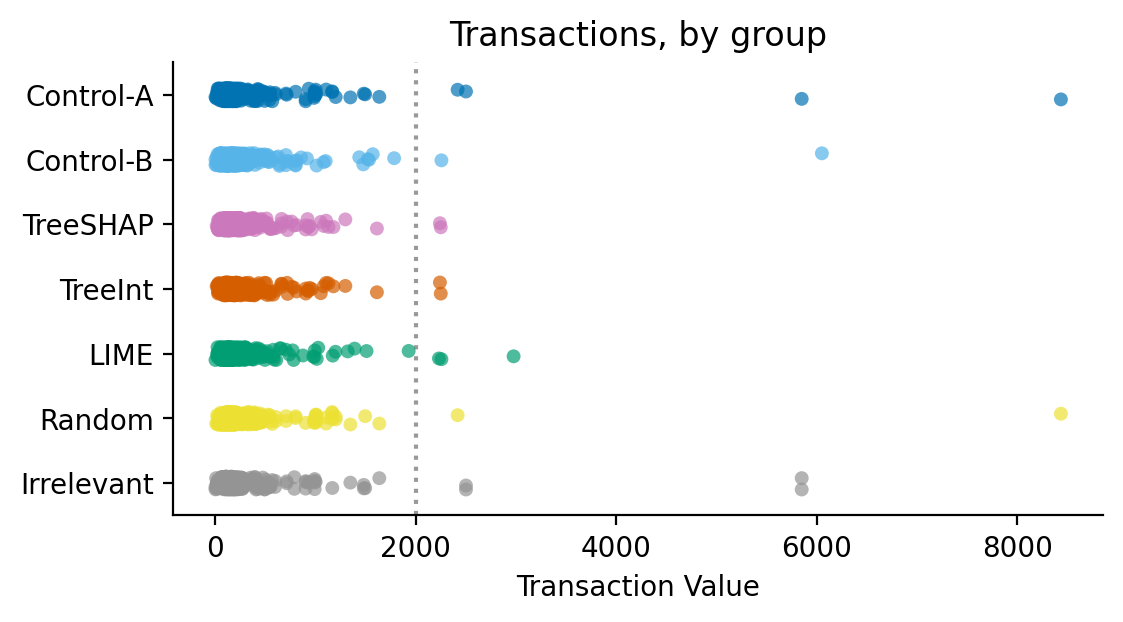

In [66]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=200)
sns.stripplot(
    x="trx_amnt", y="group", 
    data=all_decisions, alpha=0.7, 
    palette=colors, order=group_order)
plt.axvline(x=2000, color='k', linestyle=':', alpha=0.4)
sns.despine()
t = plt.title('Transactions, by group')
axes.set_xlabel('Transaction Value')
t = axes.set_ylabel('')

In [86]:
transaction_value_cap = 500
# transaction_value_cap = 2000

In [87]:
msk = all_decisions['trx_amnt'] > transaction_value_cap
all_decisions.loc[msk, 'trx_amnt'] = transaction_value_cap

In [88]:
comparisons = [
    ('Control-A', 'Control-B'),
    ('Control-B', 'LIME'),
    ('Control-B', 'TreeInt'),
    ('Control-B', 'TreeSHAP'),
    ('Control-B', 'Random'),
    ('Control-B', 'Irrelevant'),
    ('TreeInt', 'Random'),
    ('TreeSHAP', 'Random'),
    ('LIME', 'Random')
]

In [89]:
def print_significant_tests(ttest_res, alpha=0.1):
#     nothing_significant = True
#     for k, v in ttest_res.items():
#         if v['pval'] <= alpha:
#             nothing_significant = False
#             print(k, v)
            
#     if nothing_significant:
#         print('No statistically significant differences found!')
    msk = ttest_res['p-val'] <= alpha
    print(ttest_res[msk])
    
    if ttest_res[msk].empty:
        print('No statistically significant differences found!')

In [90]:
def ttests_operational_metrics(metrics, comparisons):
    
    results = list()

    for comp in comparisons:
        mean1 = metrics[metrics['group'] == comp[0]]['mean'].iloc[0]
        mean2 = metrics[metrics['group'] == comp[1]]['mean'].iloc[0]
        
        var1 = metrics[metrics['group'] == comp[0]]['var'].iloc[0]
        var2 = metrics[metrics['group'] == comp[1]]['var'].iloc[0]

        n1 = metrics[metrics['group'] == comp[0]]['n'].iloc[0]
        n2 = metrics[metrics['group'] == comp[1]]['n'].iloc[0]
        
        res = stats.ttest_ind_from_stats(
            mean1, np.sqrt(var1), n1,
            mean2, np.sqrt(var2), n2,
        )
        
        
        d = dict()
        d['comparison'] = comp
        d['t-stat'] = res.statistic
        d['p-val'] = res.pvalue
        
        results.append(d)
        
    return pd.DataFrame(results)

#### Dollars made per Second

Correct
               comparison     p-val    t-stat
0  (Control-A, Control-B)  0.009411 -2.601834
3   (Control-B, TreeSHAP)  0.084323  1.727865
6       (TreeInt, Random)  0.058330 -1.895407
7      (TreeSHAP, Random)  0.041883 -2.037327
Approve
                comparison     p-val    t-stat
2     (Control-B, TreeInt)  0.023824  2.263442
3    (Control-B, TreeSHAP)  0.038392  2.073402
5  (Control-B, Irrelevant)  0.003441  2.932311
Decline
                comparison     p-val    t-stat
2     (Control-B, TreeInt)  0.016482  2.402138
3    (Control-B, TreeSHAP)  0.025487  2.237309
5  (Control-B, Irrelevant)  0.001409  3.201821
Ignore
                comparison     p-val    t-stat
2     (Control-B, TreeInt)  0.025013  2.244699
3    (Control-B, TreeSHAP)  0.027070  2.213873
5  (Control-B, Irrelevant)  0.001597  3.165241


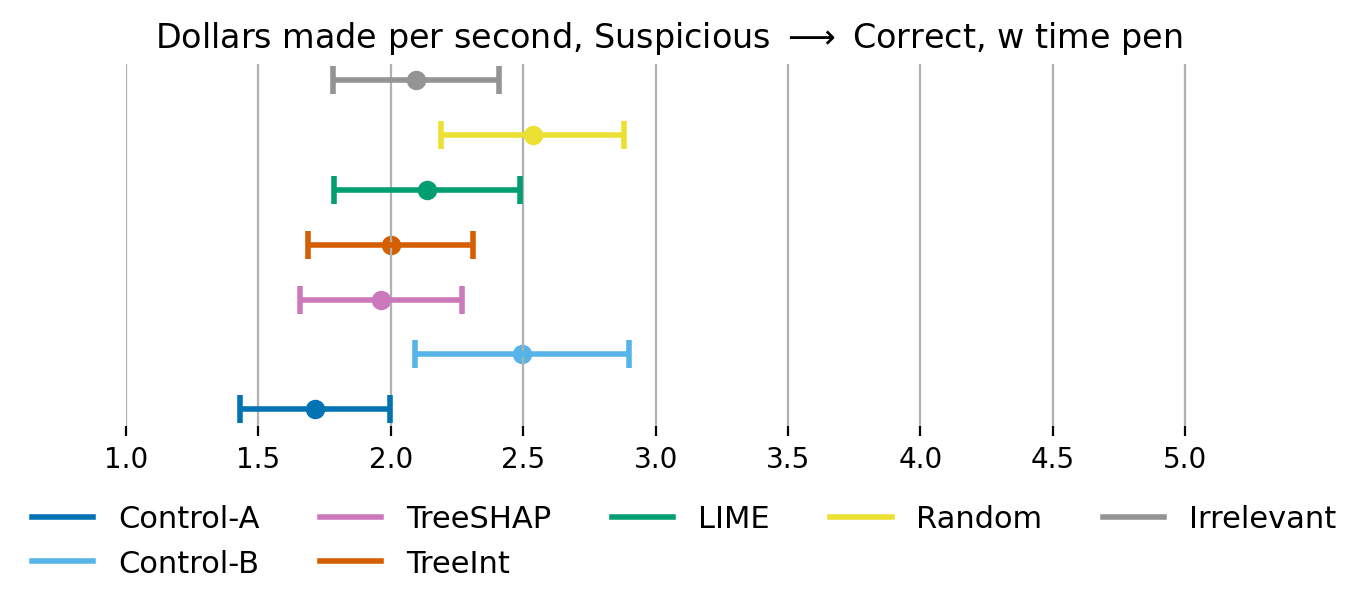

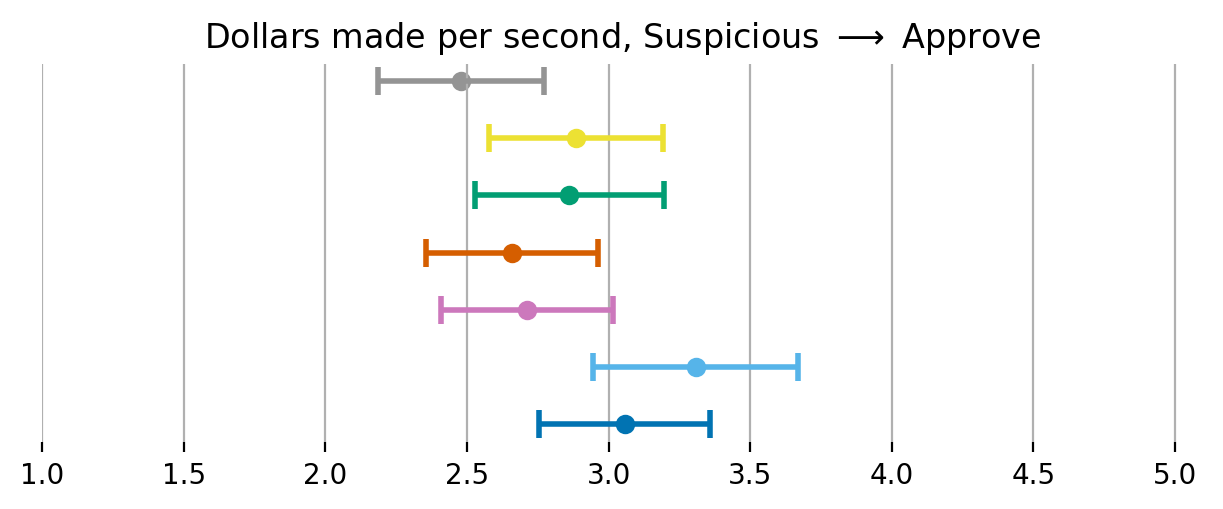

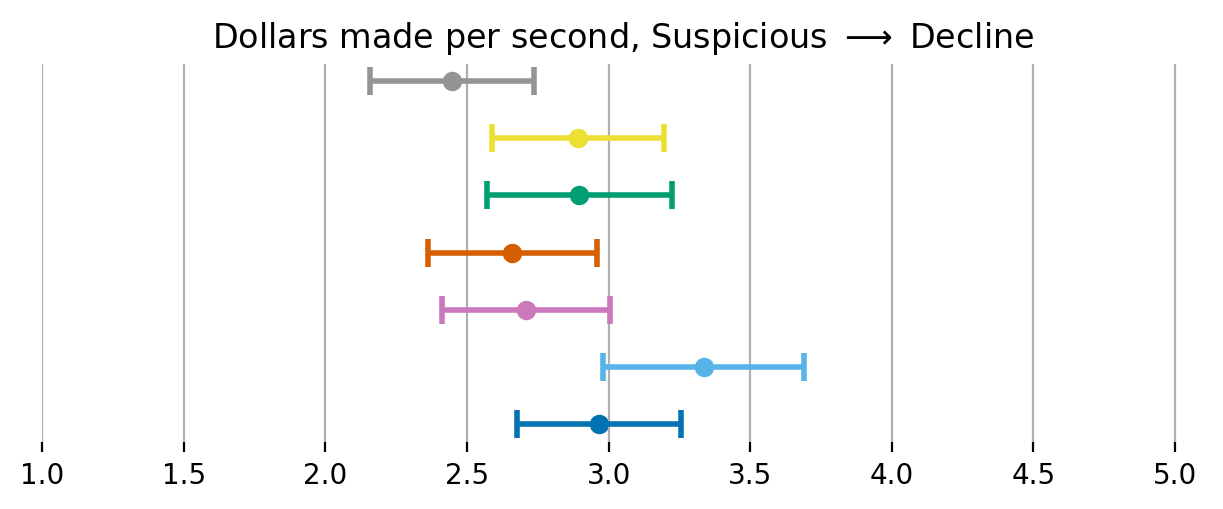

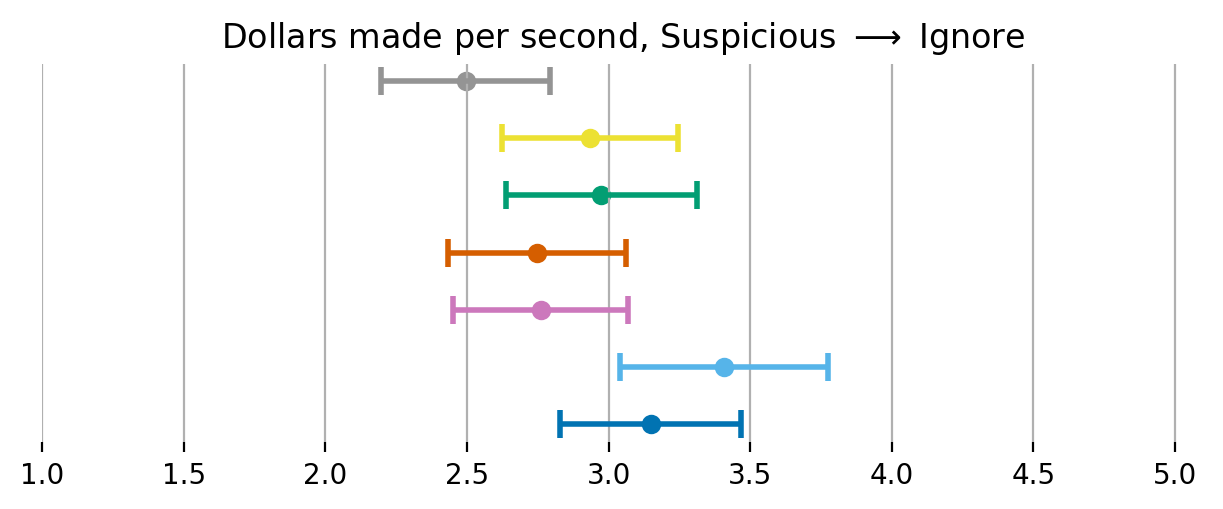

In [91]:
df = dps(all_decisions, params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, 
              title='Dollars made per second, Suspicious $\longrightarrow$ Correct, w time pen', 
              xlim=[1, 5.1], legend=True
             )
ttests = ttests_operational_metrics(df, comparisons)
print('Correct')
print_significant_tests(ttests)


df = dps(all_decisions, params, 'approve', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Approve', xlim=[1, 5.1], legend=False)
ttests = ttests_operational_metrics(df, comparisons)
print('Approve')
print_significant_tests(ttests)



df = dps(all_decisions, params, 'decline', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Decline', xlim=[1, 5.1], legend=False)
ttests = ttests_operational_metrics(df, comparisons)
print('Decline')
print_significant_tests(ttests)

df = dps(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Dollars made per second, Suspicious $\longrightarrow$ Ignore', xlim=[1, 5.1], legend=False)
ttests = ttests_operational_metrics(df, comparisons)
print('Ignore')
print_significant_tests(ttests)


#### Average Decision Time

Correct
                comparison     p-val    t-stat
0   (Control-A, Control-B)  0.000673  3.410986
2     (Control-B, TreeInt)  0.035436 -2.106218
3    (Control-B, TreeSHAP)  0.019479 -2.340039
5  (Control-B, Irrelevant)  0.084292 -1.728035
7       (TreeSHAP, Random)  0.089735  1.698462
approve
                comparison         p-val    t-stat
0   (Control-A, Control-B)  5.226620e-03  2.798930
1        (Control-B, LIME)  8.223104e-02 -1.739641
2     (Control-B, TreeInt)  6.314800e-05 -4.017922
3    (Control-B, TreeSHAP)  6.174074e-05 -4.023300
4      (Control-B, Random)  1.498922e-05 -4.350453
5  (Control-B, Irrelevant)  9.378707e-07 -4.935253
8           (LIME, Random)  5.867563e-03 -2.761063
decline
                comparison         p-val    t-stat
0   (Control-A, Control-B)  5.226620e-03  2.798930
1        (Control-B, LIME)  8.223104e-02 -1.739641
2     (Control-B, TreeInt)  6.314800e-05 -4.017922
3    (Control-B, TreeSHAP)  6.174074e-05 -4.023300
4      (Control-B, Random)  1.4

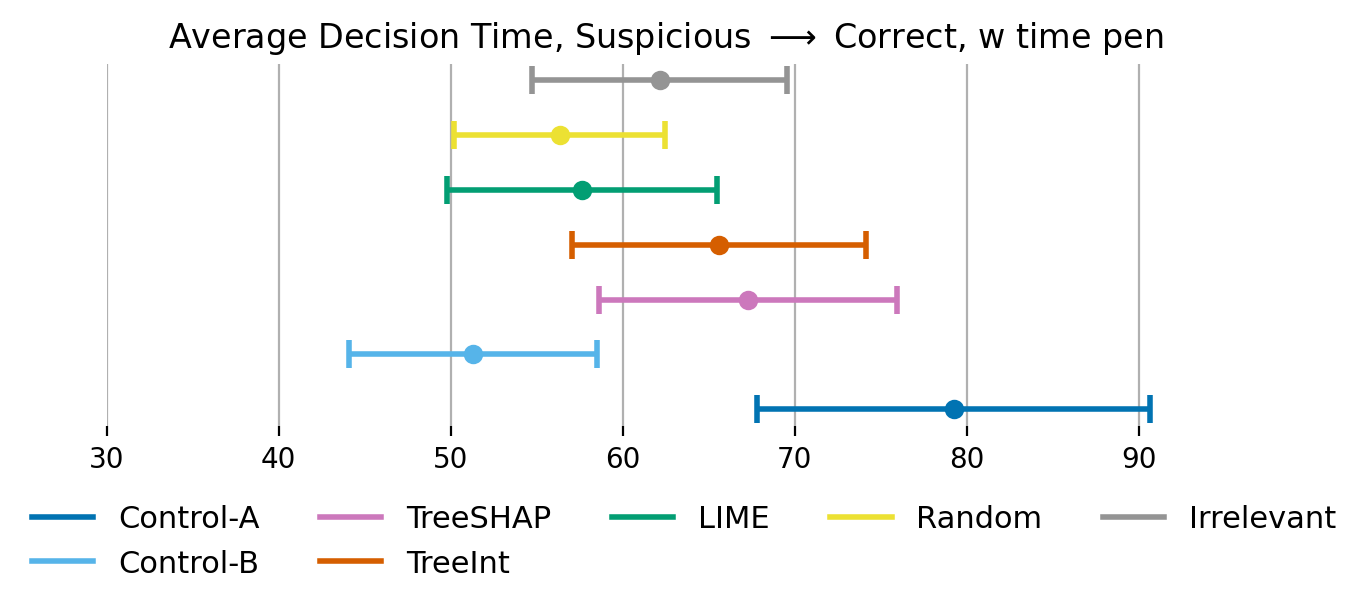

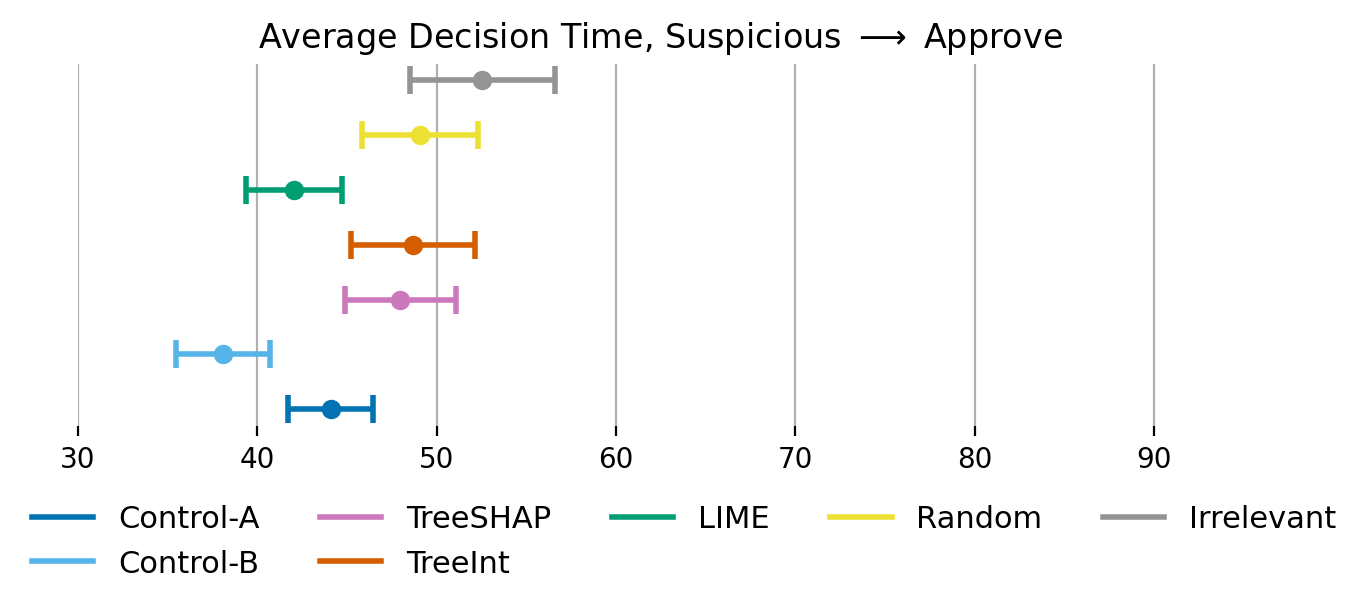

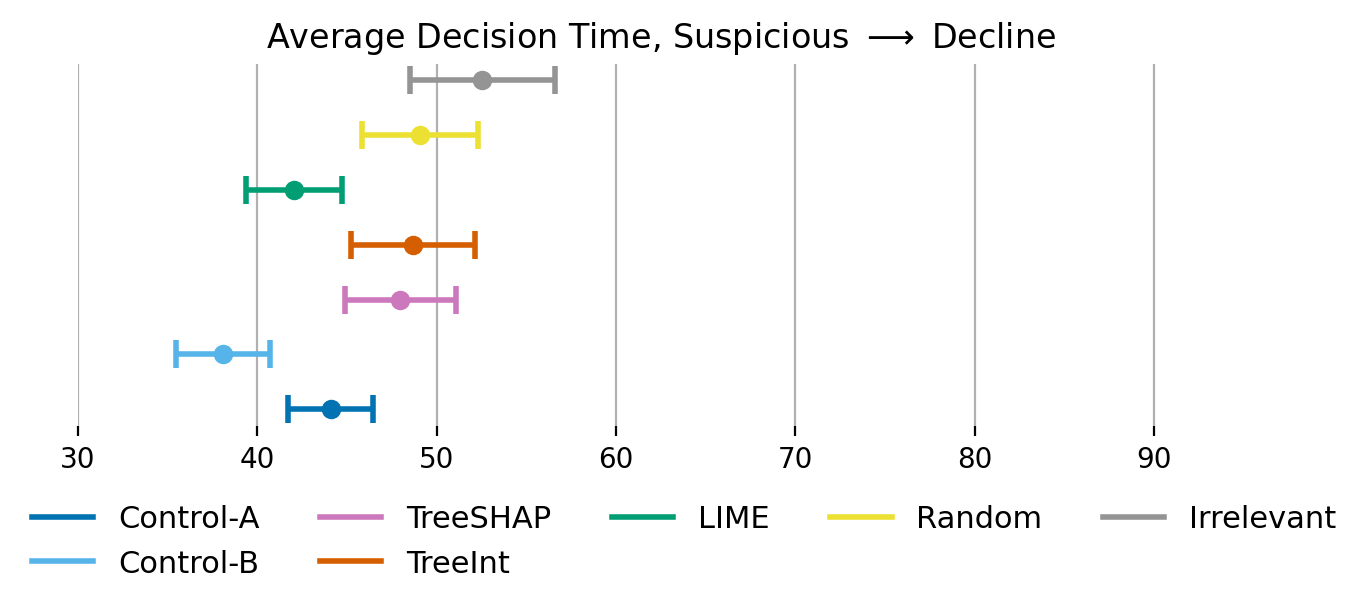

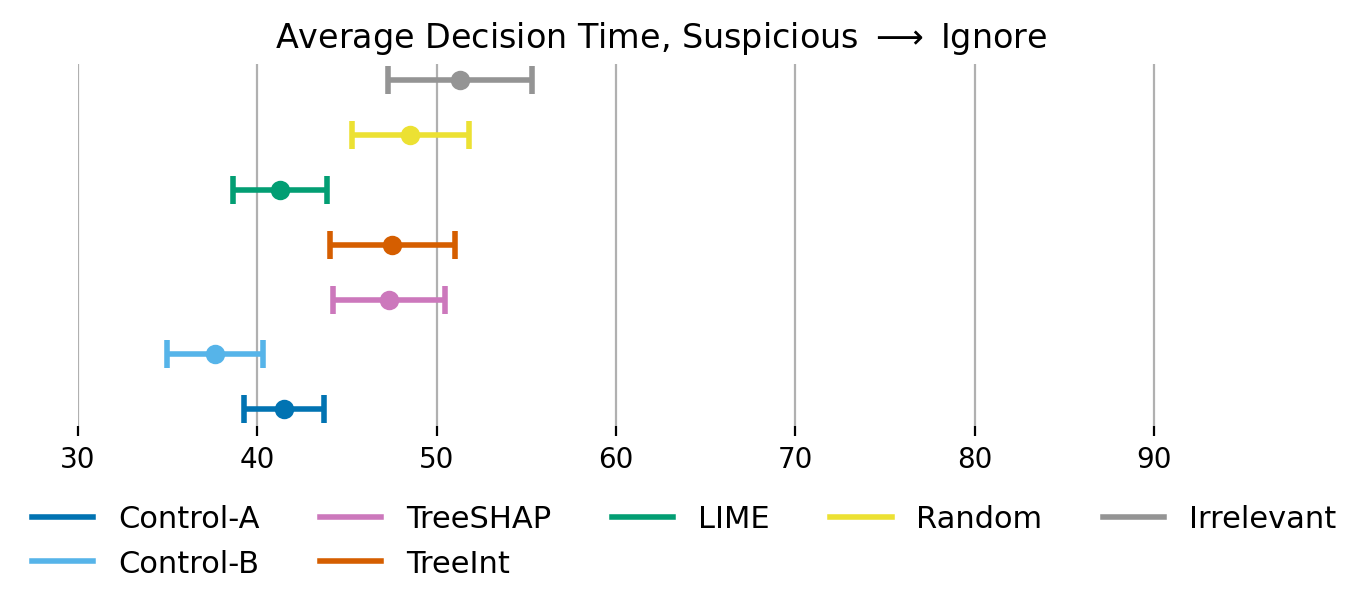

In [73]:
df = dt(all_decisions, params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Correct, w time pen', xlim=[30, 95])
ttests = ttests_operational_metrics(df, comparisons)
print('Correct')
print_significant_tests(ttests)

df = dt(all_decisions, params, 'approve', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Approve', xlim=[30, 95])
ttests = ttests_operational_metrics(df, comparisons)
print('approve')
print_significant_tests(ttests)


df = dt(all_decisions, params, 'decline', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Decline', xlim=[30, 95])
ttests = ttests_operational_metrics(df, comparisons)
print('decline')
print_significant_tests(ttests)


df = dt(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_metrics2(df, group_order, colors, title='Average Decision Time, Suspicious $\longrightarrow$ Ignore', xlim=[30, 95])
ttests = ttests_operational_metrics(df, comparisons)
print('ignore')
print_significant_tests(ttests)



#### Percent Dollar Regret

Correct
Empty DataFrame
Columns: [comparison, p-val, t-stat]
Index: []
No statistically significant differences found!
approve
Empty DataFrame
Columns: [comparison, p-val, t-stat]
Index: []
No statistically significant differences found!
decline
Empty DataFrame
Columns: [comparison, p-val, t-stat]
Index: []
No statistically significant differences found!
Ignore
Empty DataFrame
Columns: [comparison, p-val, t-stat]
Index: []
No statistically significant differences found!


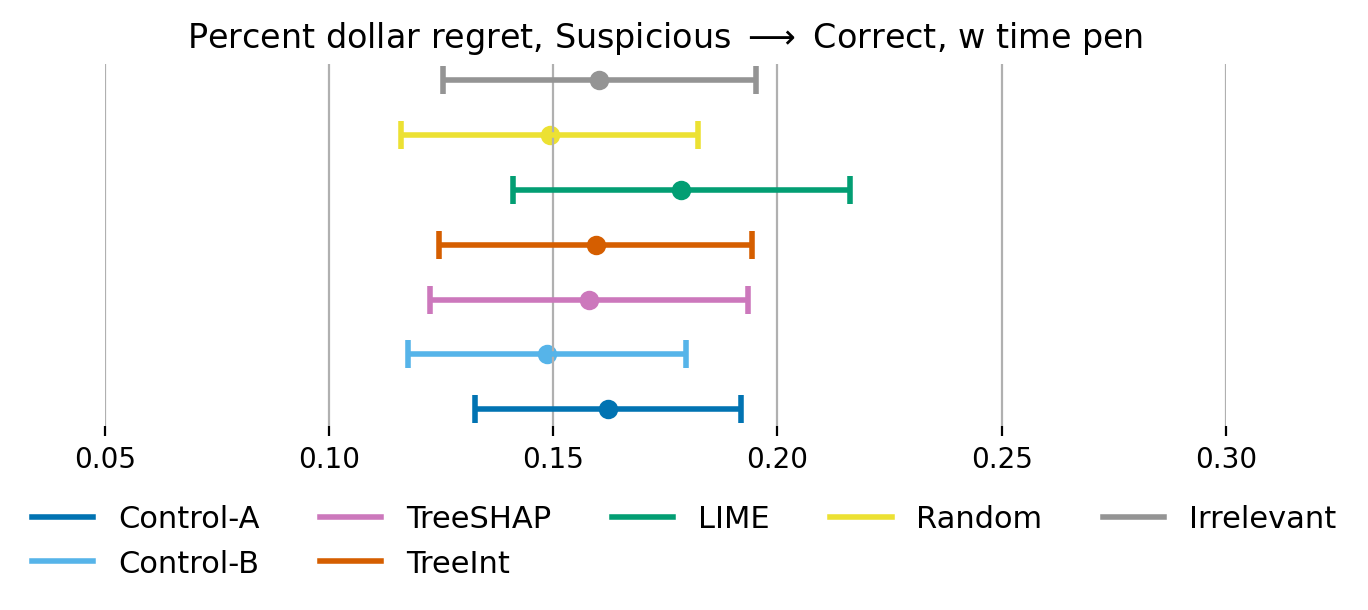

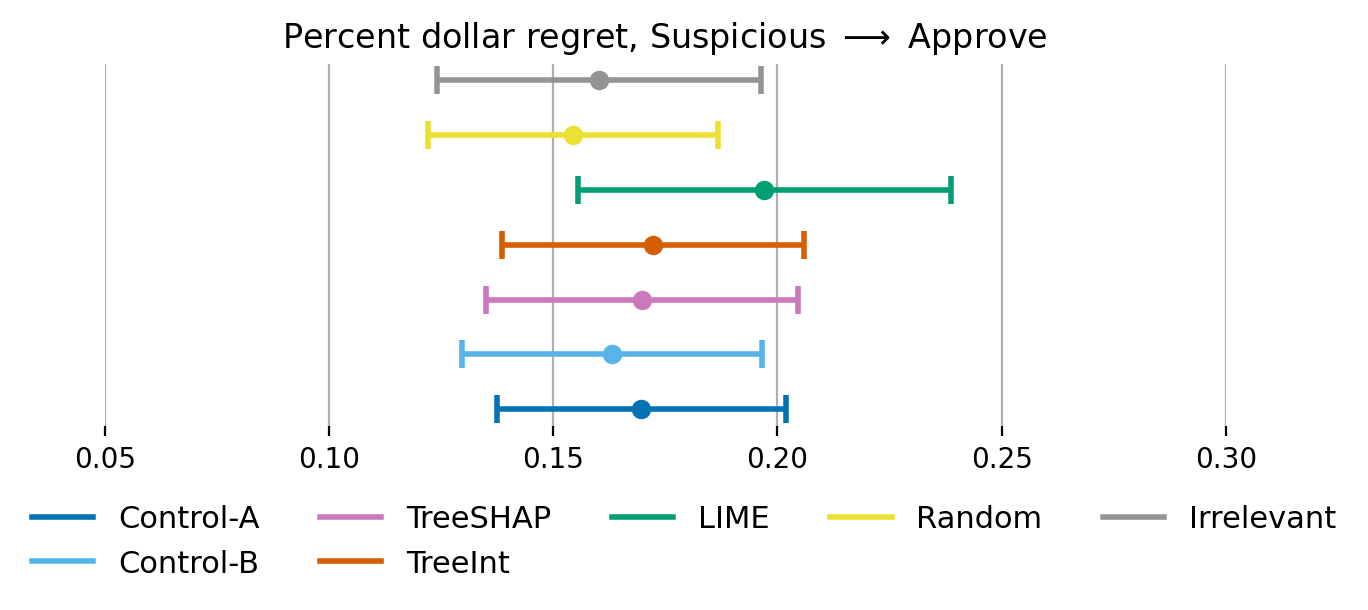

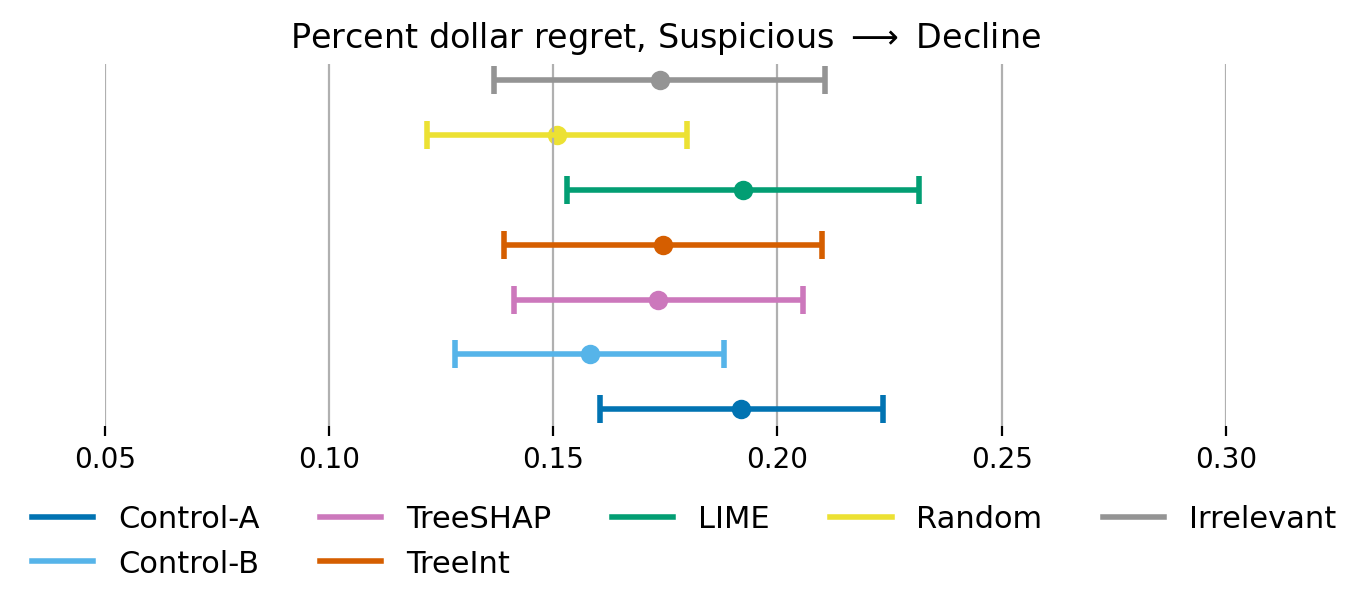

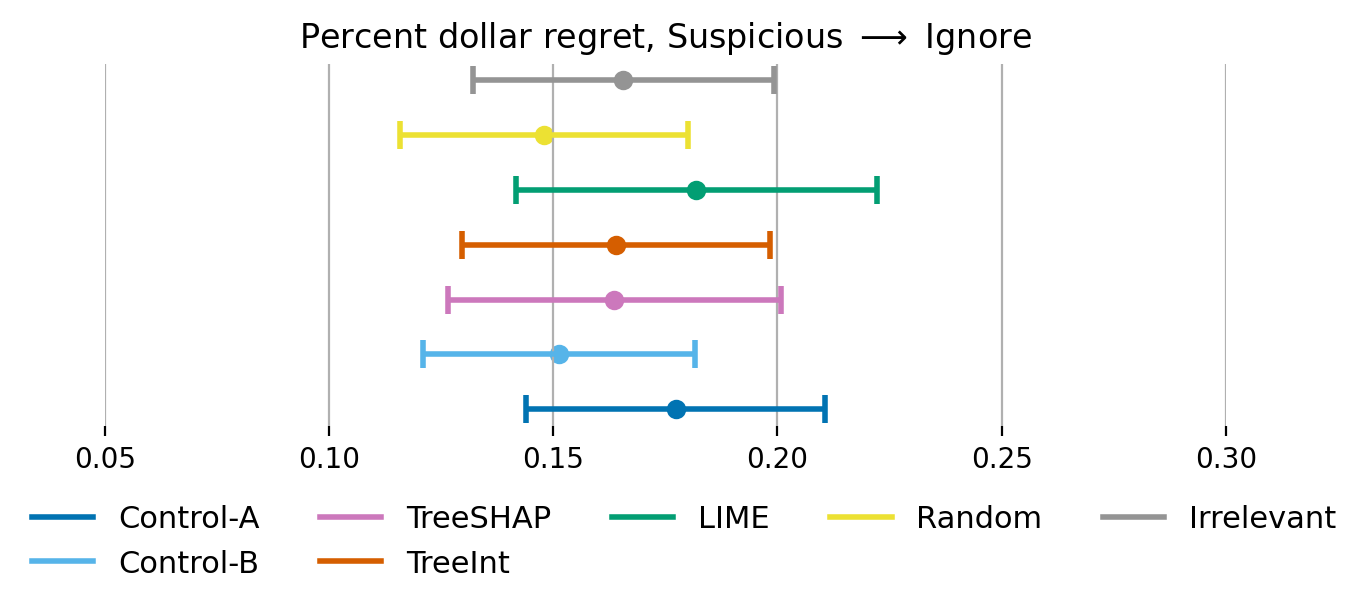

In [92]:
df = pdr(all_decisions, params, 'correct', ['group'], n_samples=500, n_iterations=100)
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Correct, w time pen', 
    legend=True,
    xlim=[0.05, 0.30]
)
ttests = ttests_operational_metrics(df, comparisons)
print('Correct')
print_significant_tests(ttests)

df = pdr(all_decisions, params, 'approve', ['group'], n_samples=500, n_iterations=100)
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Approve', 
    legend=True,
    xlim=[0.05, 0.30]
)
ttests = ttests_operational_metrics(df, comparisons)
print('approve')
print_significant_tests(ttests)

df = pdr(all_decisions, params, 'decline', ['group'], n_samples=500, n_iterations=100)
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Decline', 
    legend=True,
    xlim=[0.05, 0.30]
)
ttests = ttests_operational_metrics(df, comparisons)
print('decline')
print_significant_tests(ttests)

df = pdr(all_decisions[~suspicious_msk], params, 'correct', ['group'], n_samples=500, n_iterations=100)
plot_metrics2(
    df, group_order, colors, 
    title='Percent dollar regret, Suspicious $\longrightarrow$ Ignore', 
    legend=True,
    xlim=[0.05, 0.30]
)
ttests = ttests_operational_metrics(df, comparisons)
print('Ignore')
print_significant_tests(ttests)

#### Let's do a sweep of the parameters

We check two main things:
1. Do the rank order among the groups change with different parameter settings
2. Are the differences statistically significant even if the ranks change

In [76]:
param_grid = {
    'fn': [-0.8, -1, -1.2],
    'p_loss_trx': [0.2, 0.3, 0.4], 
    'cust_worth': [0, 1, 3, 5], 
    'p_loss_cust': [0, 0.05, 0.1, 0.3], 
    'p_return_cust': [0, 0.2, 0.3],
    'suspicious_handling': [0, 600, 1800, 3600, 'approve', 'decline'] # If this is an int, it's correct and timepenalty
}

comparisons = [
    ('Control-A', 'Control-B'),
    ('Control-B', 'LIME'),
    ('Control-B', 'TreeInt'),
    ('Control-B', 'TreeSHAP'),
    ('Control-B', 'Random'),
    ('Control-B', 'Irrelevant'),
    ('TreeInt', 'Random'),
    ('TreeSHAP', 'Random'),
    ('LIME', 'Random')
]

In [77]:
def do_parameter_sweep(
    decisions, 
    comparisons,
    fn,
    p_loss_trx, 
    cust_worth,
    p_loss_cust,
    p_return_cust,
    suspicious_handling
):
    all_param_combinations = itertools.product(
        fn, 
        p_loss_trx, 
        cust_worth, 
        p_loss_cust, 
        p_return_cust,
        suspicious_handling
    )

    results = list()
    significance_results = list()
    for config in all_param_combinations:
        
        # suspicious handling
        if isinstance(config[5], int):
            add_time= config[5]
            suspicious_strategy = 'correct'
        else:
            add_time= 0 # The value doesn't matter
            suspicious_strategy = config[5]
            
        
        param = {
            'fn': config[0],
            'p_loss_trx': config[1],
            'cust_worth': config[2],
            'p_loss_cust': config[3],
            'p_return_cust': config[4],
            'suspicious_add_time': add_time,
            'suspicious_strategy': suspicious_strategy
        }

        metrics = list()
        ttests = list()
        
        df = dt(decisions, param, suspicious_strategy, ['group'])
        df['metric'] = 'dt'
        
        ttest = ttests_operational_metrics(df, comparisons)
        ttest['metric'] = 'dt'
        
        metrics.append(df)
        ttests.append(ttest)
        
        
        df = dps(decisions, param, suspicious_strategy, ['group'])
        df['metric'] = 'dps'
        
        ttest = ttests_operational_metrics(df, comparisons)
        ttest['metric'] = 'dps'
        
        metrics.append(df)
        ttests.append(ttest)
        
        df = pdr(decisions, param, suspicious_strategy, ['group'], n_samples=500, n_iterations=100)
        df['metric'] = 'pdr'
        
        ttest = ttests_operational_metrics(df, comparisons)
        ttest['metric'] = 'pdr'
        
        metrics.append(df)
        ttests.append(ttest)
        
        res = pd.concat(metrics)
        sig_res = pd.concat(ttests)
        
        # appending the parameter values
        for p, v in param.items():
            res[p] = v
            sig_res[p] = v


        results.append(res)
        significance_results.append(sig_res)

    
    return pd.concat(results), pd.concat(significance_results)


**Cell below is commented out to stop accidentally running it**

In [79]:
# metrics, significance_tests = do_parameter_sweep(all_decisions, comparisons, **param_grid)

# metrics.to_csv('param_sweep_op_metrics.csv')
# significance_tests.to_csv('param_sweep_significance.csv')

In [46]:
metrics_param_sweep = pd.read_csv('param_sweep_op_metrics.csv').drop(columns='Unnamed: 0')

In [47]:
significance_param_sweep = pd.read_csv('param_sweep_significance.csv').drop(columns='Unnamed: 0')

In [97]:
cols = ['fn', 'p_loss_trx', 'cust_worth', 'p_loss_cust', 'p_return_cust', 'suspicious_add_time', 'suspicious_strategy']

In [96]:
s = None
for c in cols:
    if s in None:
        s = significance_param_sweep[c]
        continue
    
    s = 
    

,comparison,p-val,t-stat,metric,fn,p_loss_trx,cust_worth,p_loss_cust,p_return_cust,suspicious_add_time,suspicious_strategy
0,"('Control-A', 'Control-B')",0.005227,2.798930,dt,-0.8,0.2,0,0.0,0.0,0,correct
1,"('Control-B', 'LIME')",0.082231,-1.739641,dt,-0.8,0.2,0,0.0,0.0,0,correct
2,"('Control-B', 'TreeInt')",0.000063,-4.017922,dt,-0.8,0.2,0,0.0,0.0,0,correct
3,"('Control-B', 'TreeSHAP')",0.000062,-4.023300,dt,-0.8,0.2,0,0.0,0.0,0,correct
4,"('Control-B', 'Random')",0.000015,-4.350453,dt,-0.8,0.2,0,0.0,0.0,0,correct


In [48]:
grp_obj = significance_param_sweep.groupby(['comparison', 'metric'])

#### PDR -- Are any of the parameters result in statistically significant results?

In [49]:
for g, df in grp_obj:
    msk = (df['p-val'] <= 0.1) & (df['metric'] == 'pdr')
    msk2 = df['cust_worth'] == 0
    if df[msk & msk2].empty:
        continue
    
    print(df[msk & msk2]['comparison'].unique())
    

["('Control-A', 'Control-B')"]
["('Control-B', 'LIME')"]
["('LIME', 'Random')"]


**Note** -- No statistically significant differences exist in terms of dollar regret. This is the only money metric that normalizes the difference between the possible revenues in each arm

In [40]:
for g, df in grp_obj:
    msk = (df['p-val'] <= 0.1) & (df['metric'] == 'dps')
    print(df[msk]['comparison'].unique())

["('Control-A', 'Control-B')"]
[]
[]
["('Control-B', 'Irrelevant')"]
[]
[]
[]
[]
[]
[]
[]
[]
["('Control-B', 'TreeInt')"]
[]
[]
["('Control-B', 'TreeSHAP')"]
[]
[]
["('LIME', 'Random')"]
[]
[]
["('TreeInt', 'Random')"]
[]
[]
["('TreeSHAP', 'Random')"]
[]
[]


#### Revenue vs Time

In [80]:
def get_decision_rev(decisions, params, suspicious_strategy, agg_levels=['group']):
    dcs = _modify_value_and_time(decisions, params, suspicious_strategy)
    
    grpobj = dcs.groupby(agg_levels)
    
    res = list()
    
    for g, df in grpobj:
        d = dict()

        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
        
        d['mean'] = df['decision_value'].mean() 
        d['var'] = df['decision_value'].std() ** 2
        d['se'] = np.sqrt(d['var']/len(df))
        d['n'] = len(df)
        
        res.append(d)
        
    return pd.DataFrame(res)
        

def plot_time_vs_op_metric(op_metric, time_metric, group_order, title='', ylabel='', confidence=0.9, xlim=[], ylim=[]):
    
    merged = op_metric.merge(
        time_metric, on='group', suffixes=('_met', '_dt')
    )
    
    fig, ax = plt.subplots(dpi=200)
    
    for i, g in enumerate(group_order):
        msk = merged['group'] == g
        df = merged[msk]
        
        interval = stats.norm.ppf(1-(1-confidence)/2)
        
        ax.errorbar(
            df['mean_dt'],
            df['mean_met'],
            yerr=df['se_met'] * interval,
            xerr=df['se_dt'] * interval,
            color=colors[i]
        )
        ax.scatter(df['mean_dt'], df['mean_met'], color=colors[i], label=g)

    ax.legend(frameon=False, bbox_to_anchor=(1.3, 1))
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Decision Time')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)
    sns.despine()

    

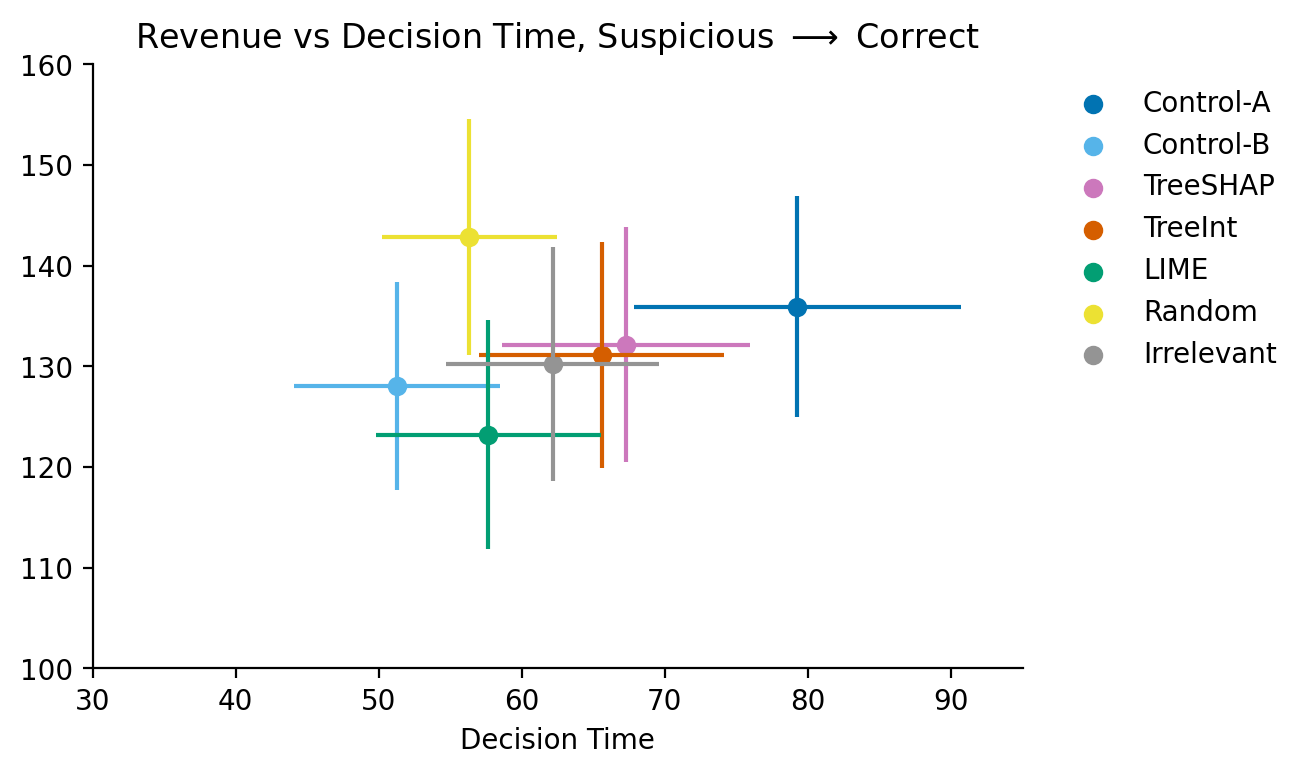

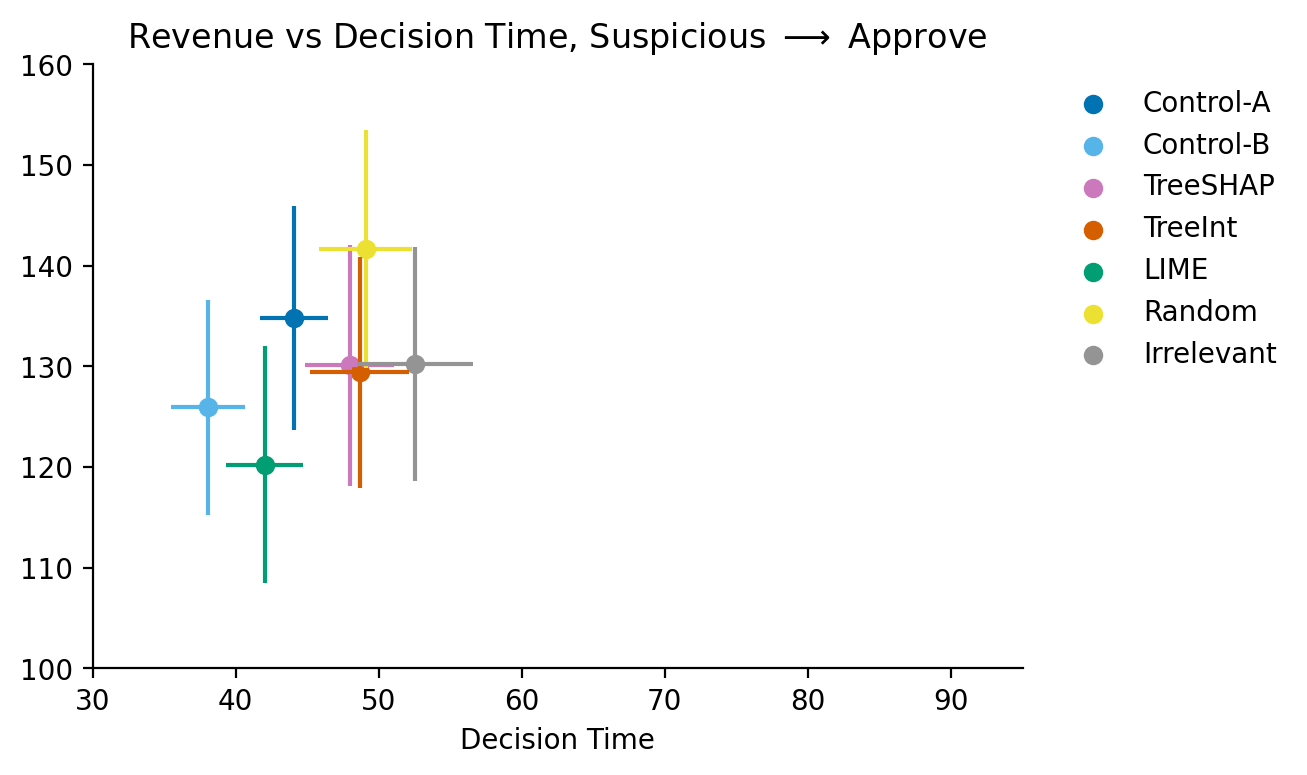

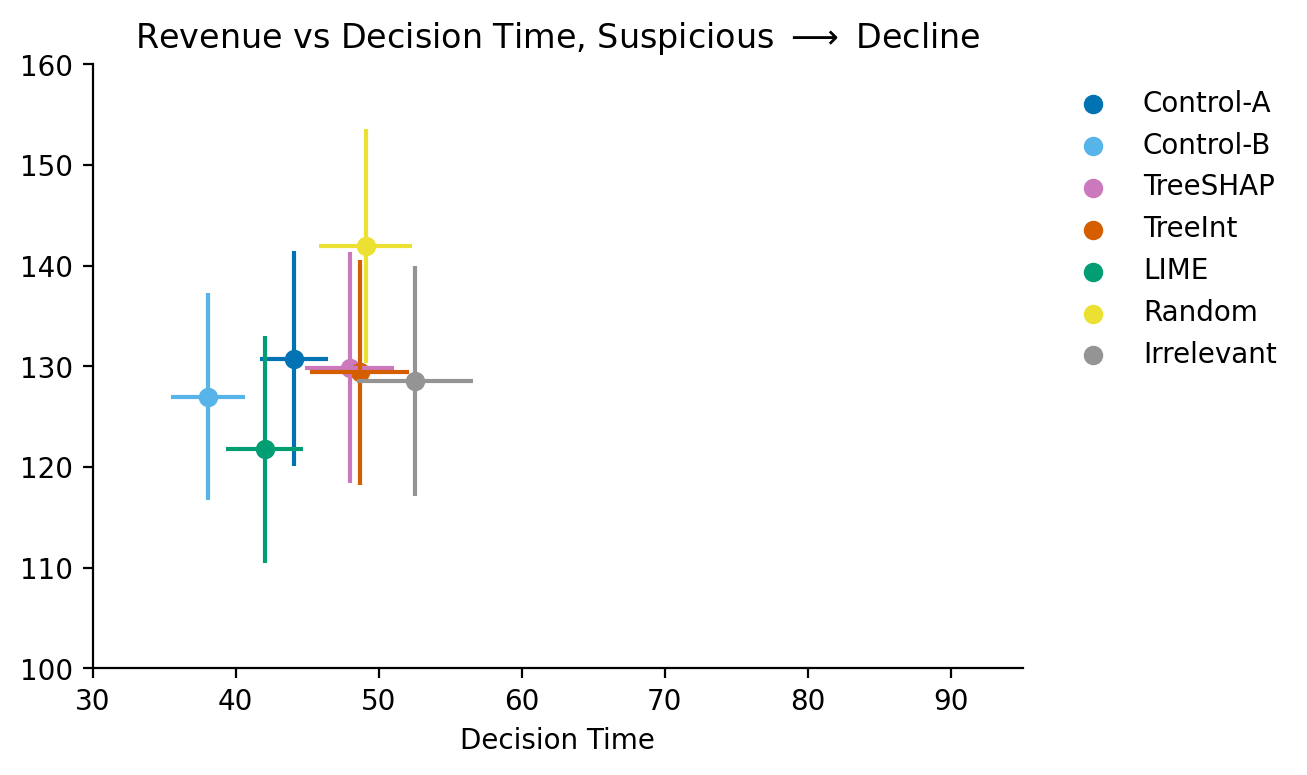

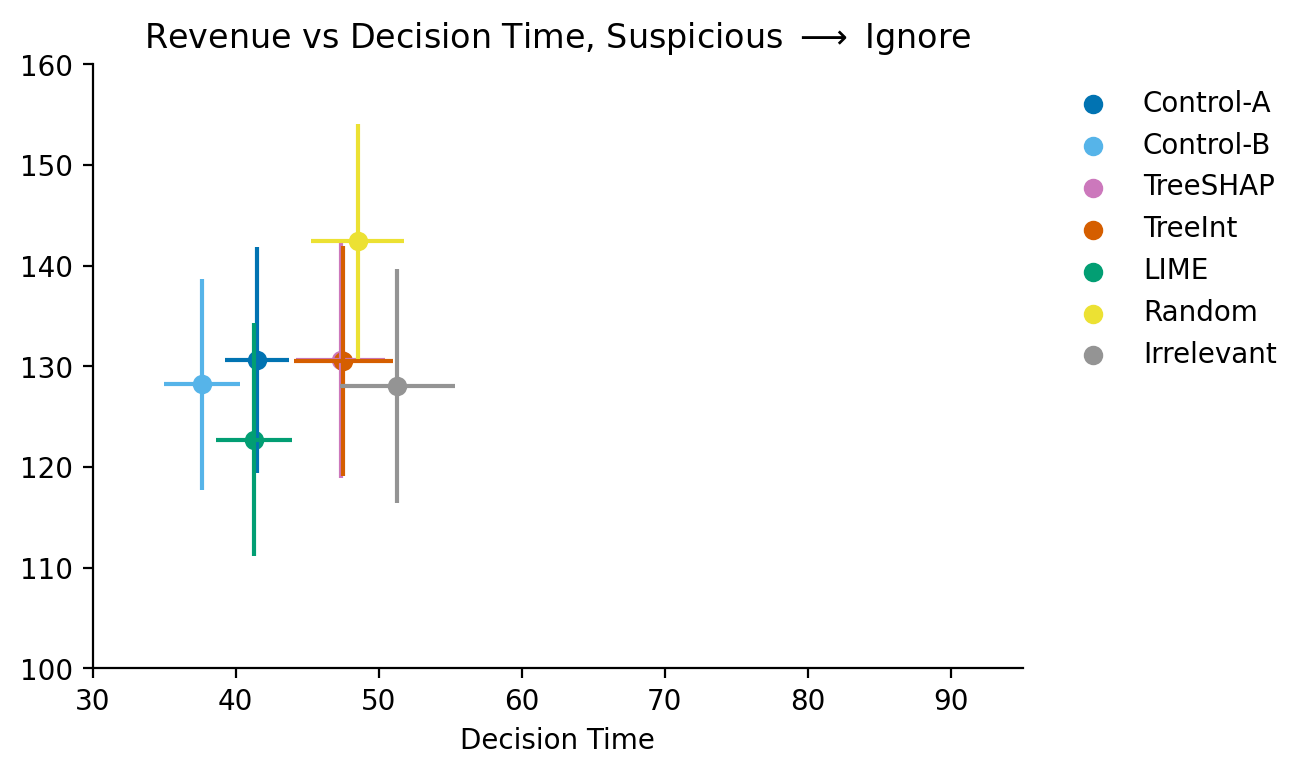

In [94]:
xlim = [30, 95]
ylim = [100, 160]


rev = get_decision_rev(all_decisions, params, 'correct', ['group'])
time = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim
)

rev = get_decision_rev(all_decisions, params, 'approve', ['group'])
time = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Approve',
    xlim=xlim,
    ylim=ylim
)

rev = get_decision_rev(all_decisions, params, 'decline', ['group'])
time = dt(all_decisions, params, 'decline', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Decline',
    xlim=xlim,
    ylim=ylim
)

rev = get_decision_rev(all_decisions[~suspicious_msk], params, 'correct', ['group'])
time = dt(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_time_vs_op_metric(
    rev, time, group_order, 
    title='Revenue vs Decision Time, Suspicious $\longrightarrow$ Ignore',
    xlim=xlim,
    ylim=ylim
)

#### Dollar Regret vs Time

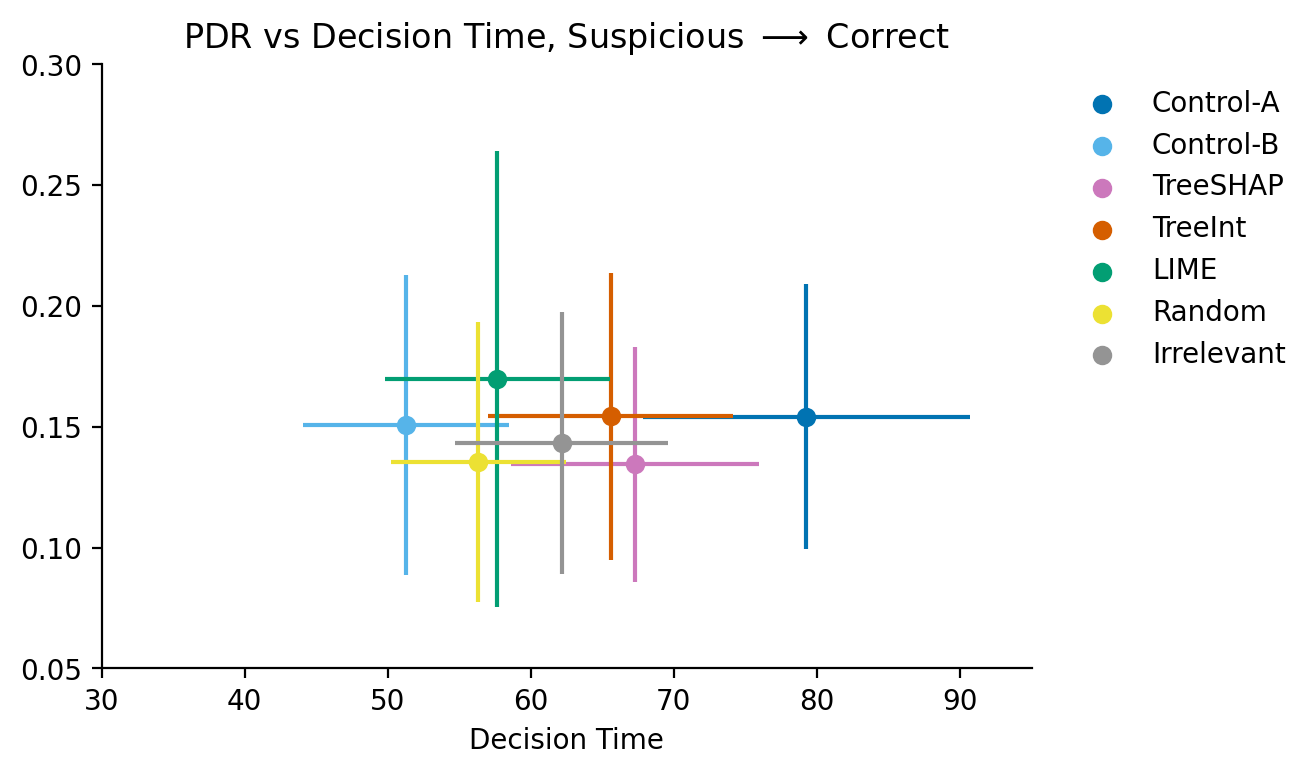

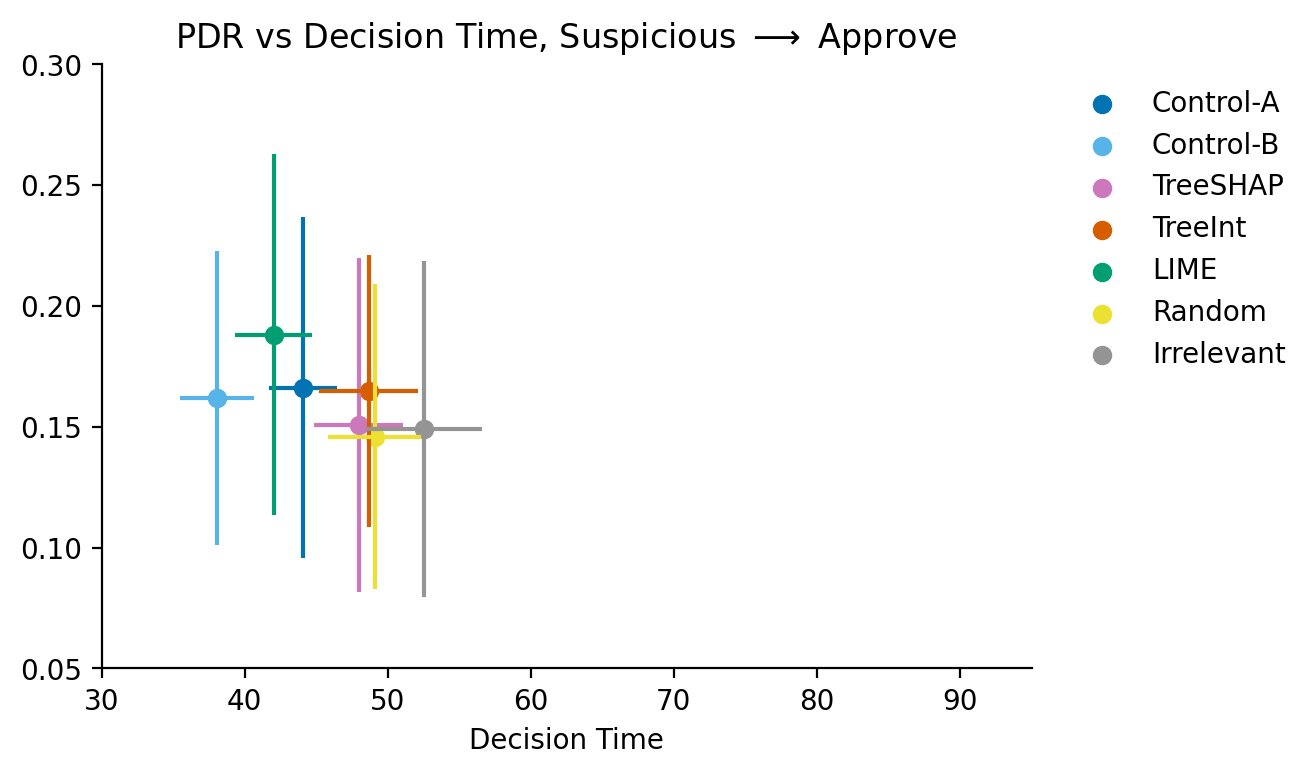

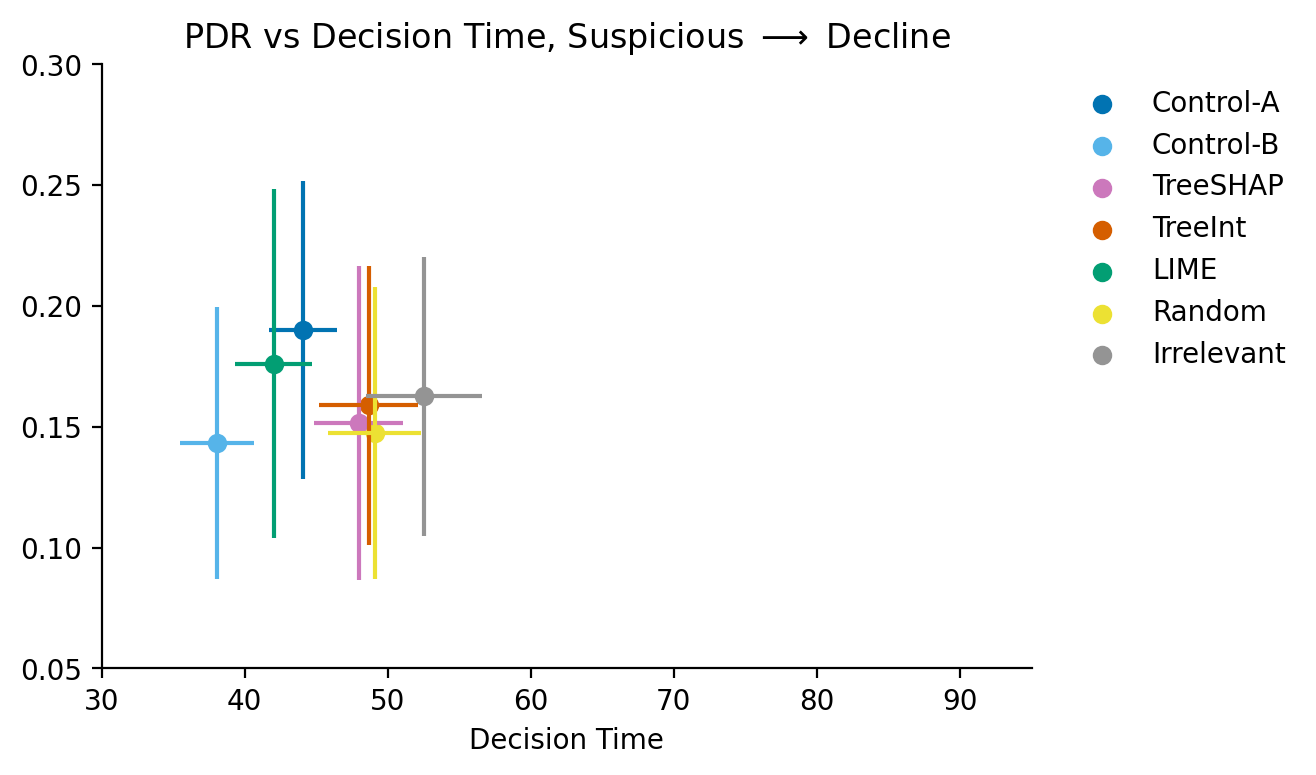

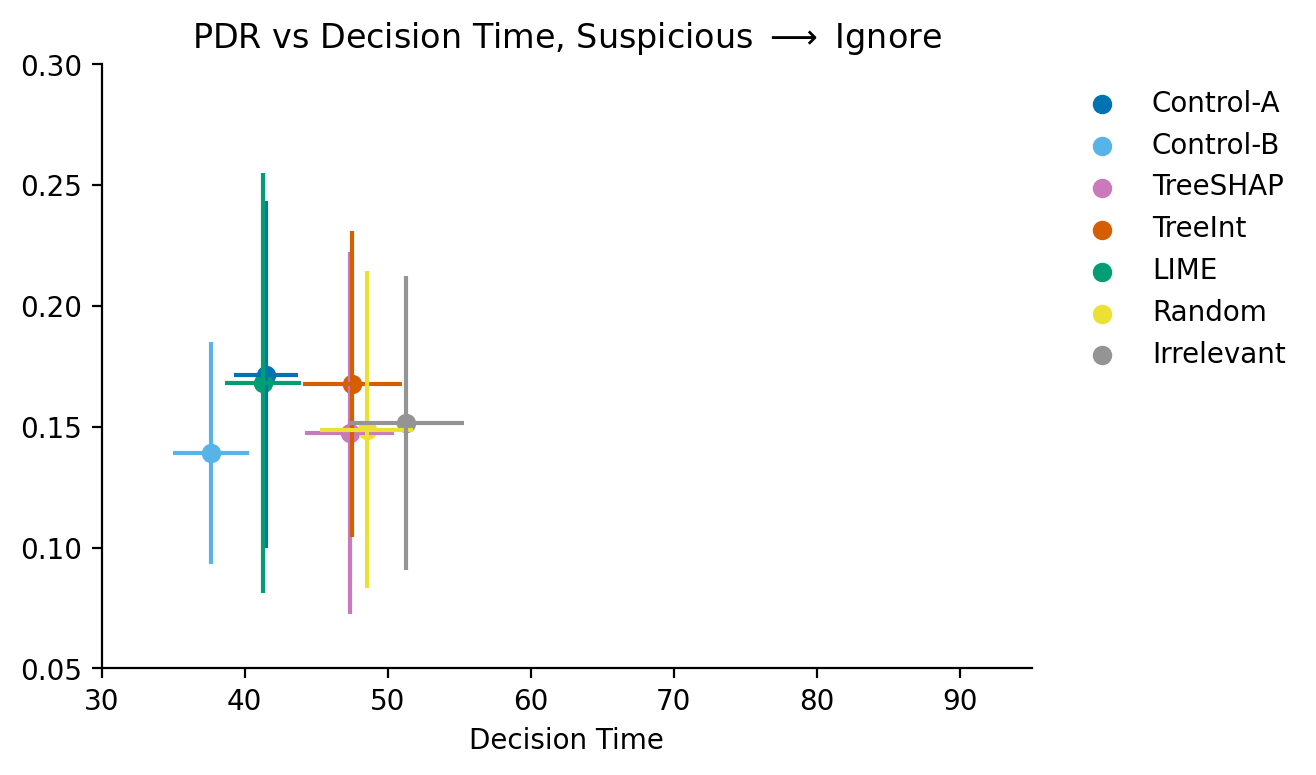

In [82]:
xlim = [30, 95]
ylim = [0.05, 0.3]


regret = pdr(all_decisions, params, 'correct', ['group'])
time = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(all_decisions, params, 'approve', ['group'])
time = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Approve',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(all_decisions, params, 'decline', ['group'])
time = dt(all_decisions, params, 'decline', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Decline',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(all_decisions[~suspicious_msk], params, 'correct', ['group'])
time = dt(all_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Ignore',
    xlim=xlim,
    ylim=ylim
)

#### Considering only T and J -- PDR vs Time

/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/kasun/.pyenv/versions/ducktales/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


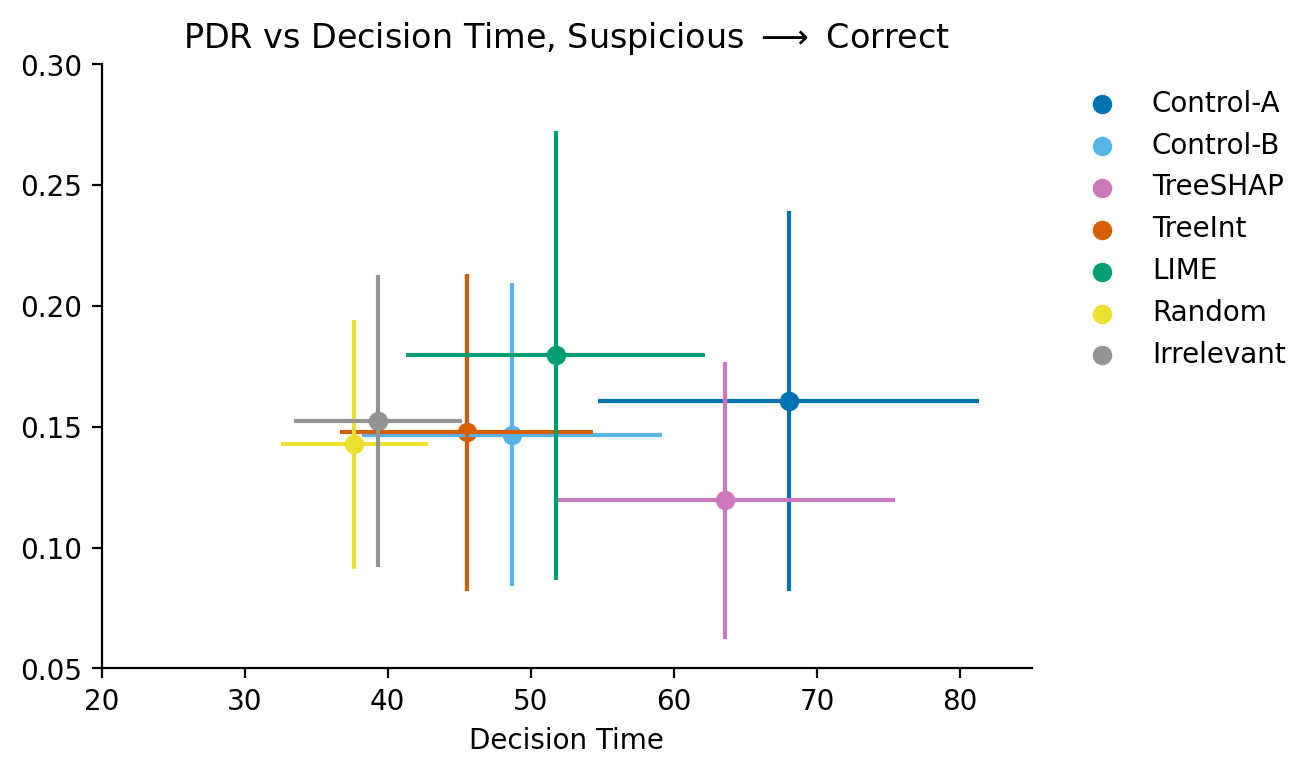

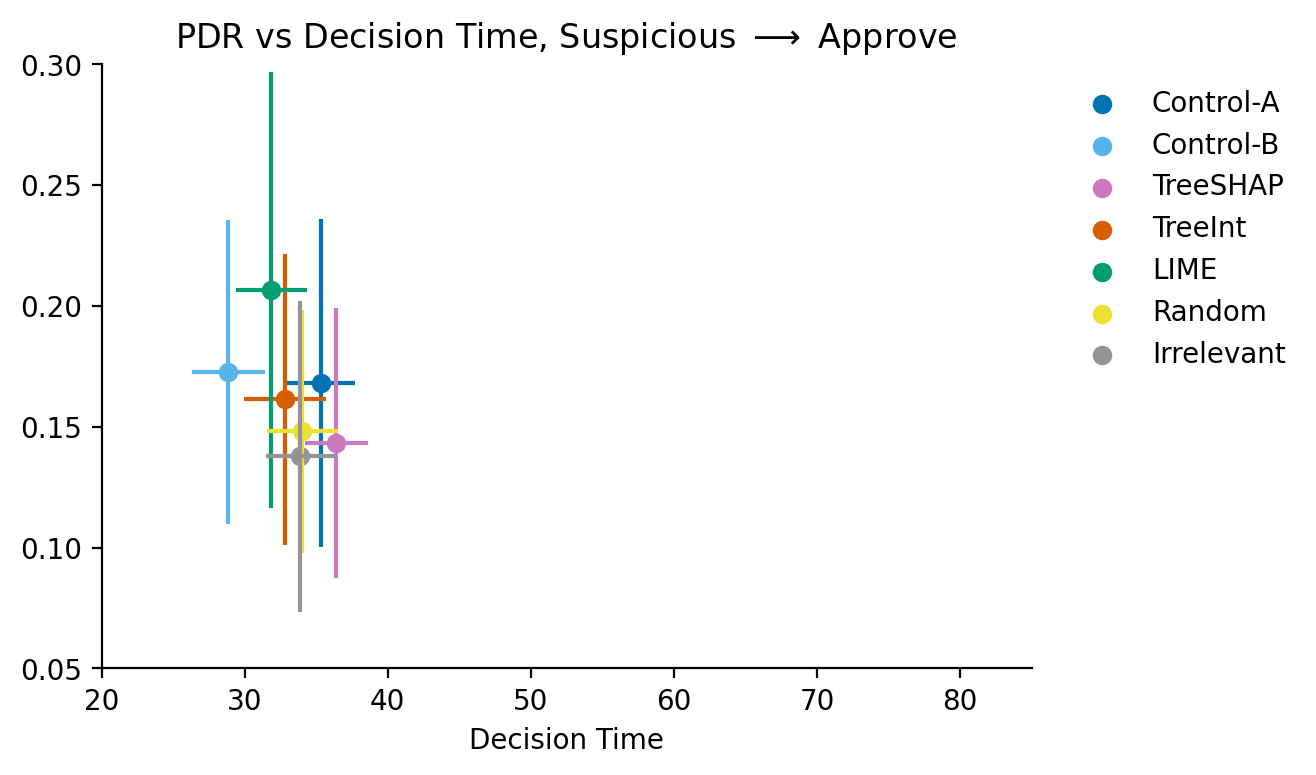

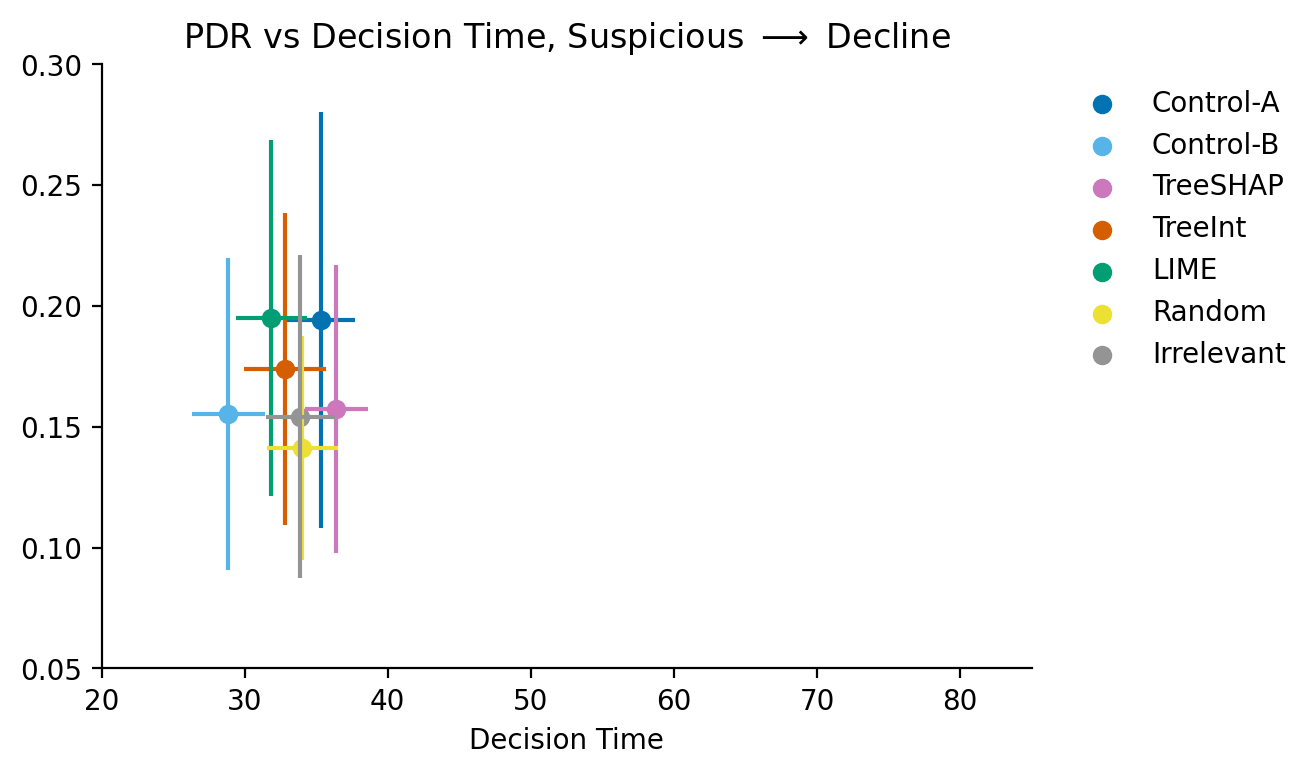

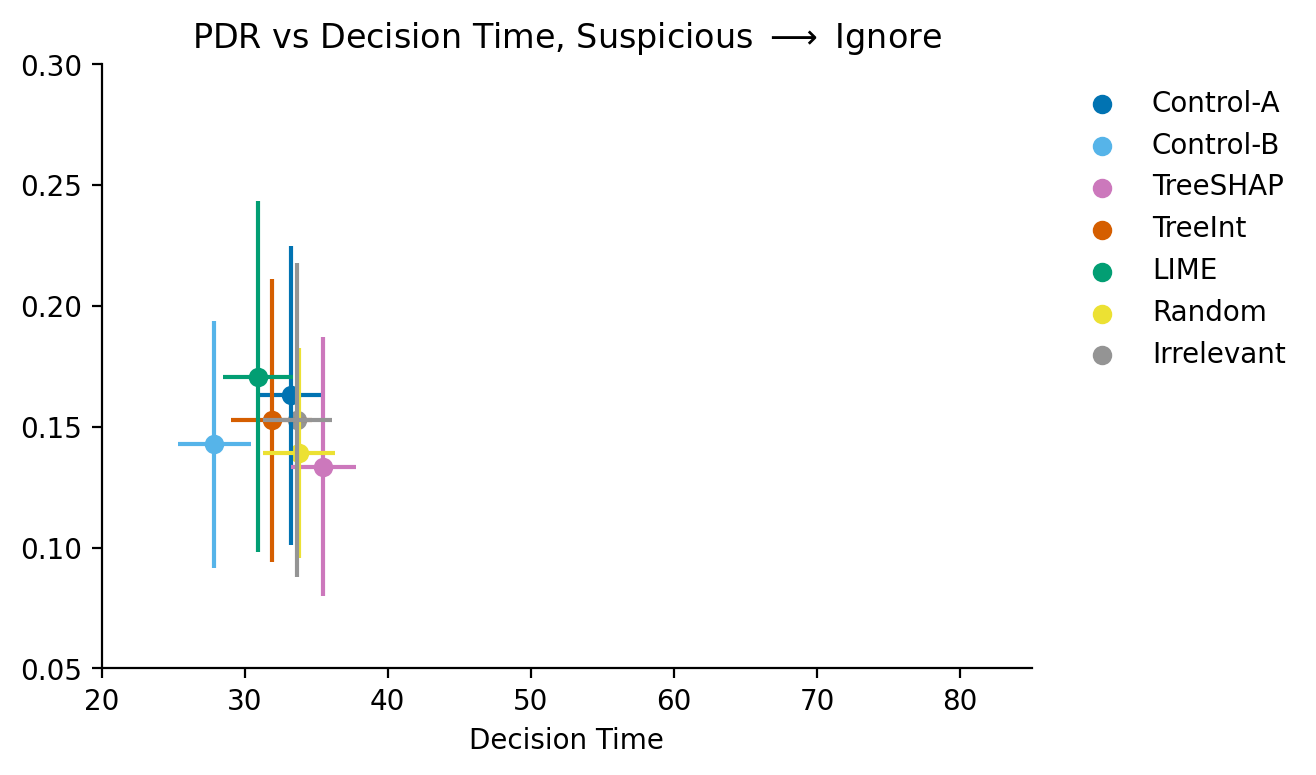

In [85]:
n_msk = all_decisions['user_name'] == 'n'

jt_decisions = all_decisions[~n_msk]

xlim = [20, 85]
ylim = [0.05, 0.3]

regret = pdr(jt_decisions, params, 'correct', ['group'])
time = dt(jt_decisions, params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Correct',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(jt_decisions, params, 'approve', ['group'])
time = dt(jt_decisions, params, 'approve', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Approve',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(jt_decisions, params, 'decline', ['group'])
time = dt(jt_decisions, params, 'decline', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Decline',
    xlim=xlim,
    ylim=ylim
)

regret = pdr(jt_decisions[~suspicious_msk], params, 'correct', ['group'])
time = dt(jt_decisions[~suspicious_msk], params, 'correct', ['group'])
plot_time_vs_op_metric(
    regret, time, group_order, 
    title='PDR vs Decision Time, Suspicious $\longrightarrow$ Ignore',
    xlim=xlim,
    ylim=ylim
)

#### Possible revenue distribution across arms

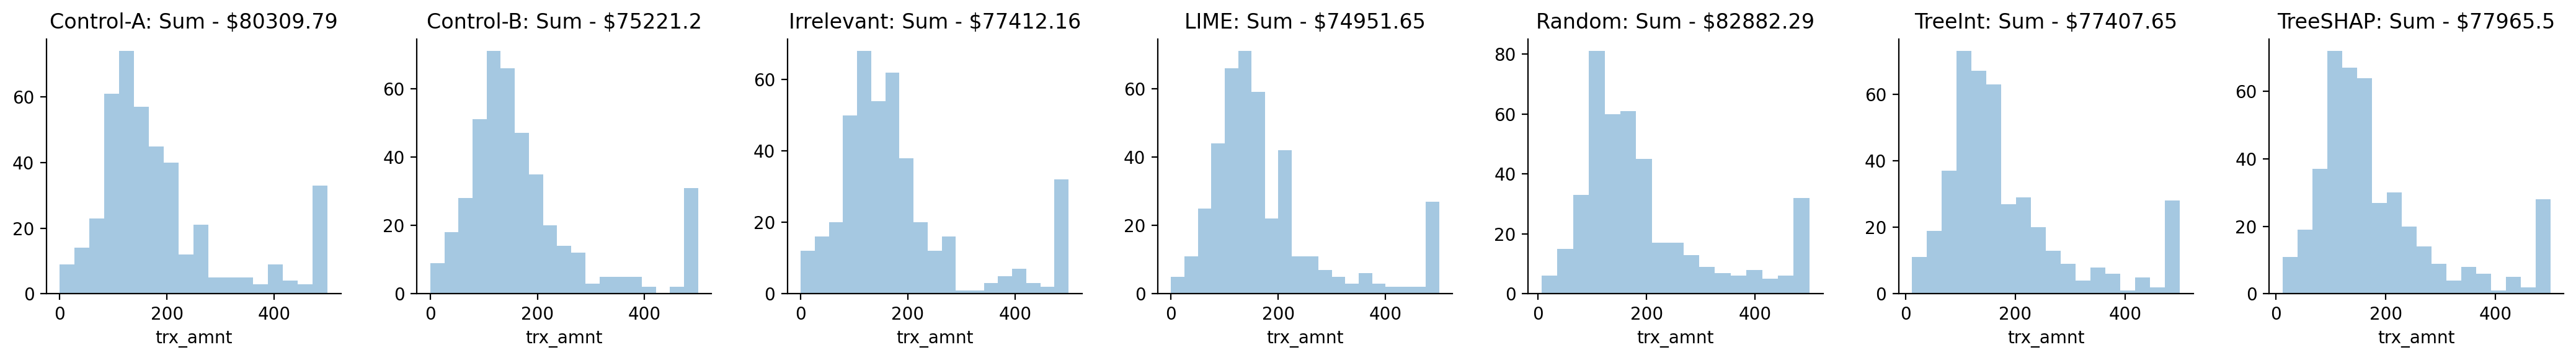

In [58]:
grp_obj = all_decisions.groupby('group')

fig, axes = plt.subplots(1, 7, figsize=(21, 3), dpi=200)
i = 0
for g, df in grp_obj:
    msk = df['label'] == 0
    ax = sns.distplot(df[msk]['trx_amnt'], kde=False, ax = axes[i])
    possible_rev = df[msk]['trx_amnt'].sum()
    title = '{}: Sum - ${}'.format(g, round(possible_rev, 2))
    ax.set_title(title)
    sns.despine()
    i = i + 1
    
plt.tight_layout()

In [59]:
all_decisions['trx_amnt'].max()

500.0

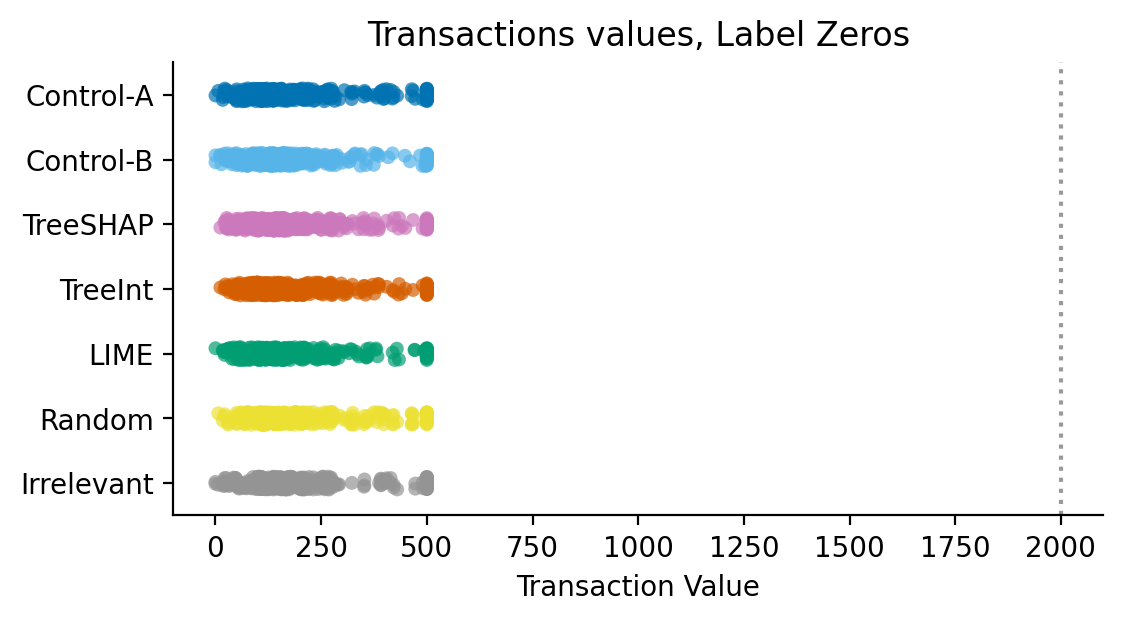

In [95]:
fig, axes = plt.subplots(figsize=(6, 3), dpi=200)
msk = all_decisions['label'] == 0
sns.stripplot(
    x="trx_amnt", y="group", 
    data=all_decisions[msk], alpha=0.7, 
    palette=colors, order=group_order)
plt.axvline(x=2000, color='k', linestyle=':', alpha=0.4)
sns.despine()

t = plt.title('Transactions values, Label Zeros')
axes.set_xlabel('Transaction Value')
t = axes.set_ylabel('')